In [1]:
import numpy as np
from splinv import detect
from splinv import hmod
from splinv import darkmapper
from splinv.grid import Cartesian
from configparser import ConfigParser

In [2]:
""" Test sparse reconstruction of weak lensing dark map
"""
# configuration
configName  =   'config_darkmapper.ini'
parser      =   ConfigParser()
parser.read(configName)

# halo simulation
z_h     =  0.2425
log_m   =  15
M_200   =  10.**(log_m)
conc    =  4
halo    =  hmod.triaxialJS02(mass=M_200,conc=conc,redshift=z_h,ra=0.,dec=0.,a_over_c = 1, a_over_b=1.0, tri_nfw = True)


In [3]:
# Reconstruction Init
parser.set('sparse','mu','3e-4')            #step size for gradient descent
parser.set('lens','resolve_lim','0.02')     #pix
parser.set('lens','rs_base','%s' %(halo.R0))  #Mpc/h
parser.set('sparse','nframe','1' )
parser.set('transPlane','scale','2' )
parser.set('transPlane','nx','48' )
parser.set('transPlane','ny','48' )
parser.set('lens','SigmaFname','WB00Sigma_inf148_OLS03.fits')

In [4]:
parser['lens']['rs_base']

'0.44113821185751700416'

In [5]:
# Pixelation
Grid    =   Cartesian(parser)
lensKer1=   Grid.lensing_kernel(deltaIn=False)

general_grid    =   hmod.triaxialJS02_grid_mock(parser)#hmod.nfwCS02_grid(parser)
#data2  =   general_grid.add_halo_from_dsigma(halo,add_noise = False)
data3,gErrval  =   general_grid.add_halo_from_dsigma(halo,add_noise = True)
#gErr    =   np.ones(Grid.shape)*gErrval

In [6]:
# get noise std
all_noise = np.zeros((100,10,48,48),dtype=np.complex64)
for i in range(100):
    all_noise[i,:,:,:] = general_grid.calc_noise(halo)
dg1 = all_noise.real
dg2 = all_noise.imag
noise_std = np.zeros((10,48,48))
for l in range(48):
    for m in range(48):
        for n in range(10):
            noise_std[n,l,m] = np.sqrt(np.std(dg1[:,n,l,m])**2 + np.std(dg2[:,n,l,m])**2)

In [7]:
gErr    =   noise_std

/Users/a1/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


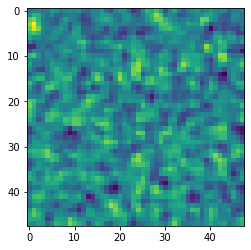

In [8]:
import matplotlib.pyplot as plt
plt.imshow(data3[9].real)

In [9]:
dmapper =   darkmapper(parser,data3.real,data3.imag,gErr,lensKer1)

dmapper.lbd=4.      # Lasso penalty
dmapper.lcd=0.      # Ridge penalty in Elastic net
dmapper.nonNeg=True # using non-negative Lasso
dmapper.clean_outcomes()
dmapper.fista_gradient_descent(3000) # run 3000 steps
w   =   dmapper.adaptive_lasso_weight(gamma=2.) # determine the apaptive weight
dmapper.fista_gradient_descent(3000,w=w)        # run adaptive lasso

dmapper.mu=3e-3     # step size for gradient descent
for _ in range(3):  # redo apaptive lasso
    w   =   dmapper.adaptive_lasso_weight(gamma=2.)
    dmapper.fista_gradient_descent(3000,w=w)
dmapper.reconstruct()


preparing numerical frames!!!!


In [10]:
c1  =   detect.local_maxima_3D(dmapper.deltaR)[0][0]
print(c1)
#np.testing.assert_equal(c1,np.array([4,Grid.ny//2,Grid.nx//2]))
logm_est=   np.log10((dmapper.alphaR*dmapper._w)[3,0,24,24])+14.
#np.testing.assert_almost_equal(logm_est,log_m,1)

[ 4 23 24]


/var/folders/vc/1pffqvxd44q6_lz4rrdn58zh0000gn/T/ipykernel_80289/3747105969.py:4: RuntimeWarning: divide by zero encountered in log10
  logm_est=   np.log10((dmapper.alphaR*dmapper._w)[3,0,24,24])+14.


In [11]:
logm_est

-inf

In [12]:
#import matplotlib.pyplot as plt
#plt.imshow(general_grid.add_halo(halo)[0][4])

If the halo is to small/light to be detected, the situation can be redeemed by increasing the resolution of the grid. 